In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px

In [2]:
%matplotlib inline
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (18, 10)
plt.rcParams['axes.titlesize'] = 16

In [3]:
typeSpecification = {"Aircraft Model": str, "Engine Model": str, "Engine3 Position": str, "Engine1 Position": str}
df = pd.read_csv('../database/aircraft_wildlife_strikes.zip', compression='zip', dtype=typeSpecification)

## Estimating the height at which the incidents occur

As we saw in the Exploratory Analysis, most incidents occur in the late stages of the flight, when the aircraft is closer to the ground. Taking a look at the column `Height` , we see more evidence of this hypothesis, noting that the commercial aircraft typically fly between $31.000$ and $38.000$ feet, according to [this source](https://time.com/5309905/how-high-do-planes-fly/).

Therefore, we can use bootstrap to estimate the average height where there happens wildlife strikes. We take $1000$ samples of the size of our dataframe ($103677$ rows) from the data with reposition and compute an approximation to the confidence interval from the population.

In [4]:
df['Height'].describe()

count    103677.000000
mean        831.032283
std        1803.650833
min           0.000000
25%           0.000000
50%          50.000000
75%         800.000000
max       31300.000000
Name: Height, dtype: float64

<AxesSubplot:ylabel='Count'>

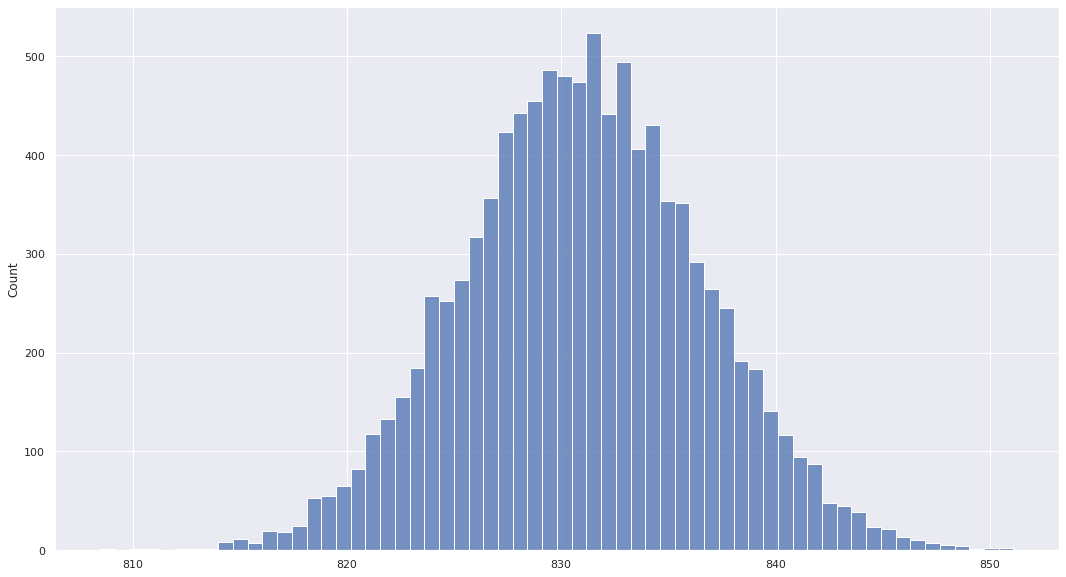

In [5]:
means = list()
height_df = df[['Record ID', 'Height']].dropna()
for _ in range(10000):
    sample = height_df.sample(n = len(height_df), replace = True)
    means.append(sample['Height'].mean())

sns.histplot(means)

In [6]:
print(f"Confidence Interval of 95%: [{np.percentile(means, 2.5)}, {np.percentile(means, 97.5)}]")

Confidence Interval of 95%: [819.9529987364604, 841.8730113718568]


We can conclude, with $95\%$ certainty, that the average height in feet at which wildlife strikes occur is in the interval $[819.95, 841.87]$.

## Are there times of the year when more accidents occur?

This is a natural question to ask, taken into account that seasons influences animal's behavior. If this effect impacts the occurrences of strikes, we might perceive some seasonal tendencies in the data, which could motivate preemptive actions at the corresponding times of the year.

According to [this](https://www.perkypet.com/advice/bird-watching/bird-migration-facts/timing) source, the birds migrate to the south during late summer through the autumn and come back in the late winter. Our data also shows that most strike occurences are in Texas, Florida and California, which are southern states.

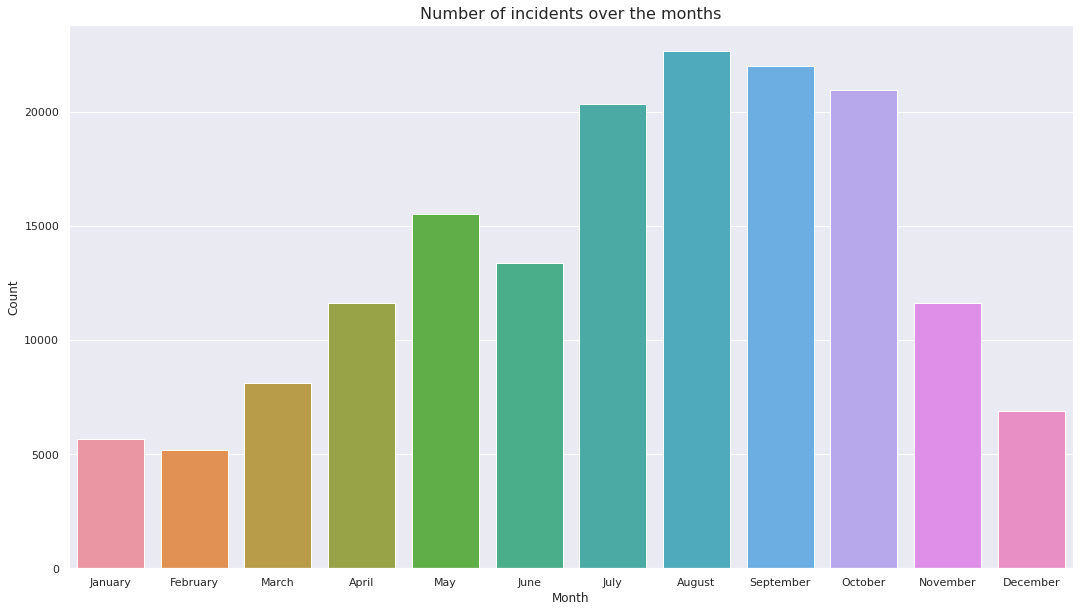

In [7]:
# Removing incidents in 2015, which would skew the data
months = [ "January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December" ]
df = df[df['Incident Year'] != 2015]
incidents_by_month = df[['Record ID', 'Incident Month']].groupby('Incident Month').count().reset_index().rename(columns={'Record ID': 'Count'})
incidents_by_month['Month'] = incidents_by_month['Incident Month'].apply(lambda x: months[x - 1])
sns.barplot(data=incidents_by_month, x='Month', y='Count')
plt.title('Number of incidents over the months')
plt.show()

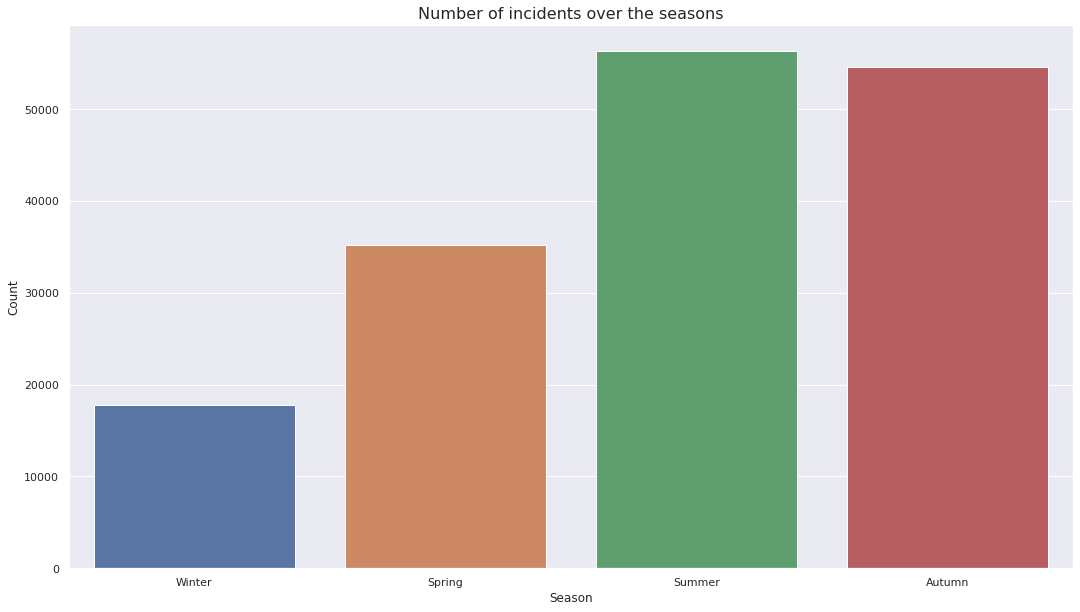

In [8]:
def season(month):
    if month == 12 or month <= 2:
        return 'Winter'
    elif month >= 3 and month <= 5:
        return 'Spring'
    elif month >= 6 and month <= 8:
        return 'Summer'
    else:
        return 'Autumn'
incidents_by_month['Season'] = incidents_by_month['Incident Month'].apply(season)
incidents_by_season = incidents_by_month[['Month', 'Season', 'Count']].groupby('Season').sum().reset_index()
season_order = ["Winter", "Spring", "Summer", "Autumn"]
sns.barplot(data=incidents_by_season, x='Season', y='Count', order=season_order)
plt.title('Number of incidents over the seasons')
plt.show()

### Hypothesis: Most wildlife strikes occur in Summer and Autumn

In order to test this hypothesis, we can run an experiment with bootstrap. We take $1000$ samples of the size of our dataframe ($163956$ rows) from the data with reposition and compute an approximation to the confidence interval from the population. The statistic considered is the number of strikes that occur in the Autumn and the Summer in comparison with the total number of strikes in the sample.

In the conditions of the experiment, the **null hypothesis** states that there's no difference between the number of incidents that happen at the each season. Because of this, the number of incidents observed in the `Summer` and `Autumn` should be half of the total number of incidents; that is, $81987$ from $163956$ incidents should happen in the `Summer` or the `Autumn`.

As it is important that the resampling size corresponds to the size of the whole sample, and our dataset is large, it takes a few minutes to run the bootstrap.

<AxesSubplot:ylabel='Count'>

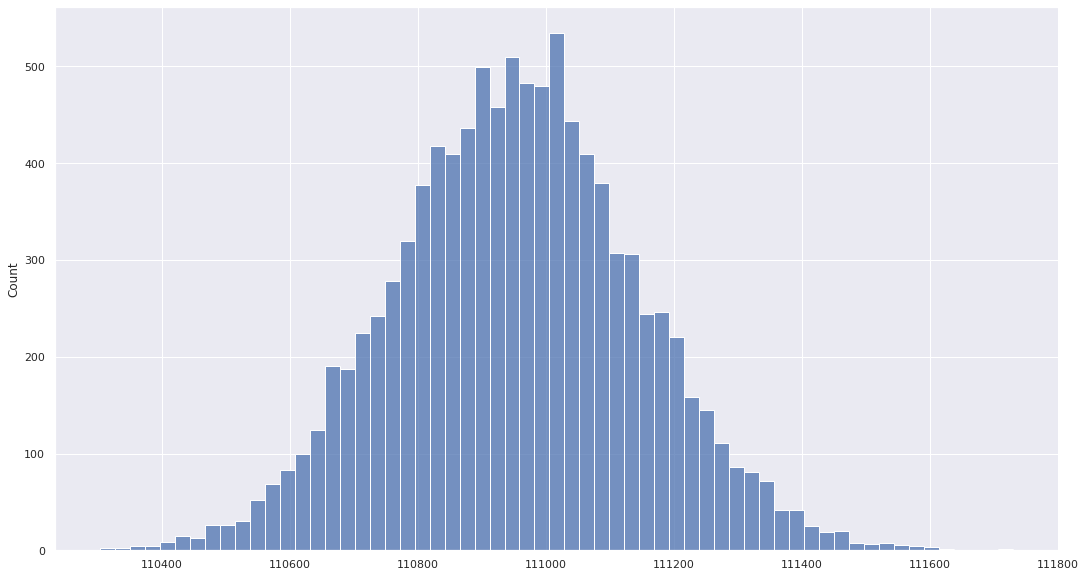

In [9]:
counts = list()
seasons_df = df[['Record ID', 'Incident Month']]
for _ in range(10000):
    sample = seasons_df.sample(n = len(seasons_df), replace = True)
    sample['Season'] = sample['Incident Month'].apply(season)
    sample.reset_index(inplace=True)
    count_autumn_summer = len(sample[(sample['Season'] == 'Autumn') | (sample['Season'] == 'Summer')])
    counts.append(count_autumn_summer)

sns.histplot(counts)

In [10]:
print(f"Confidence Interval of 95%: [{np.percentile(counts, 2.5)}, {np.percentile(counts, 97.5)}]")

Confidence Interval of 95%: [110584.0, 111335.0]


Seeing that the $p$-value of $81987$ is not inside the confidence interval, we can reject the null hypothesis with $95\%$ of certainty.